![alt text](https://i.imgur.com/1WaY7aA.png)

# Black Cat Data - Data Science and AI
## Lab 10.5: Predict Text Using Keras

We'll build a model which can predict the next word based on previous words.

### What is Predictive Text?

Predictive text is input technology where one key or button throws possibilities of many letters — such as on the numeric keypads of mobile phones and in accessibility technologies. Each key press results in a prediction rather than repeatedly sequencing through the same group of letters it represents, in the same, invariable order. [1](https://analyticsindiamag.com/predictive-text-analysis-changing-communication/)

Here is a great example of predictive text where a bot have written a whole chapter of Harry Potter!

**<blockquote class="twitter-tweet"><p lang="en" dir="ltr">We used predictive keyboards trained on all seven books to ghostwrite this spellbinding new Harry Potter chapter <a href="https://t.co/UaC6rMlqTy">https://t.co/UaC6rMlqTy</a> <a href="https://t.co/VyxZwMYVVy">pic.twitter.com/VyxZwMYVVy</a></p>&mdash; Botnik Studios (@botnikstudios) <a href="https://twitter.com/botnikstudios/status/940627812259696643?ref_src=twsrc%5Etfw">December 12, 2017</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>**

### Nietzsche

We will use Friedrich Nietzsche’s [Beyond Good and Evil](https://en.wikipedia.org/wiki/Beyond_Good_and_Evil) as a training corpus for our model.


## Load Corpus

Load corpus and and use lowerscase to make all texts lower.

What is the length of corpus?

In [2]:
path = '../DATA/nietzsche.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 600901


## Load Necessary Libraries

We'll be using tenserflow, keras for this lab.

In [3]:
import numpy as np
np.random.seed(42)

import tensorflow as tf
tf.set_random_seed(42)

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop

import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns

from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

Using TensorFlow backend.


## Preprocessing

### Unique Characters of Corpus

Let's find out all unique characters in the corpus . Create char to index and index to char.

In [4]:
# Find out all unique characters in the corpus
chars = sorted(list(set(text)))

# Create char to index and index to char.
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 59


## Create Chunk and Next Characters for Each Chunk

Next, let’s cut the corpus into chunks of 40 characters, spacing the sequences by 3 characters. Additionally, we will store the next character (the one we need to predict) for every sequence:

In [5]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 200287


## Features & Target Variables

It is time for generating our features and labels. We will use the previously generated sequences and characters that need to be predicted to create one-hot encoded vectors using the char_indices map:

In [6]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Let’s have a look at a single training sequence:

In [7]:
sentences[100]

've been unskilled and unseemly methods f'

The character that needs to be predicted for it is:

In [8]:
next_chars[100]

'o'

In [9]:
X.shape

(200287, 40, 59)

The encoded (one-hot) data looks like this:

In [10]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [11]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

## Building Model

The model we’re going to train is pretty straight forward. Single LSTM layer with 128 neurons which accepts input of shape (40 — the length of a sequence, 57 — the number of unique characters in our dataset). A fully connected layer (for our output) is added after that. It has 57 neurons and softmax for activation function:

In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.


## Training 

Our model is trained for 20 epochs using RMSProp optimizer and uses 5% of the data for validation:

In [13]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Instructions for updating:
Use tf.cast instead.
Train on 190272 samples, validate on 10015 samples
Epoch 1/20
190272/190272 [==============================] - 309s 2ms/step - loss: 2.0309 - acc: 0.4090 - val_loss: 1.7253 - val_acc: 0.4922
Epoch 2/20
190272/190272 [==============================] - 320s 2ms/step - loss: 1.6710 - acc: 0.5065 - val_loss: 1.5903 - val_acc: 0.5195
Epoch 3/20
190272/190272 [==============================] - 274s 1ms/step - loss: 1.5758 - acc: 0.5302 - val_loss: 1.5501 - val_acc: 0.5319
Epoch 4/20
190272/190272 [==============================] - 271s 1ms/step - loss: 1.5285 - acc: 0.5434 - val_loss: 1.5423 - val_acc: 0.5356
Epoch 5/20
190272/190272 [==============================] - 284s 1ms/step - loss: 1.5003 - acc: 0.5516 - val_loss: 1.5130 - val_acc: 0.5478
Epoch 6/20
190272/190272 [==============================] - 218s 1ms/step - loss: 1.4797 - acc: 0.5564 - val_loss: 1.5119 - val_acc: 0.5432
Epoch 7/20
190272/190272 [==============================] - 1

## Save and Load Model

It's time consuming to train a model. We'll save our trained model and load it to avoid trainng time later.

In [14]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [15]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

## Evaluation

Let’s have a look at how our accuracy and loss change over training epochs:

### Evaluate Accuracy

Create a plot of 
    
    history['acc']
    history['val_acc']

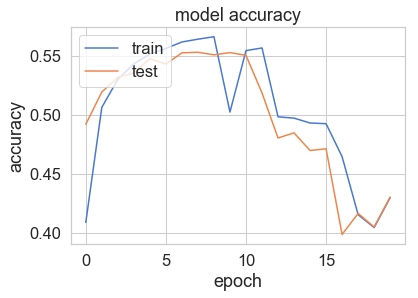

In [16]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

### Evaluate Loss

Create a plot of

    history['loss']
    history['val_loss']

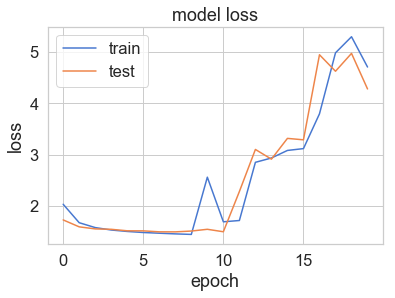

In [17]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

## Test

Finally, it is time to predict some word completions using our model! First, we need some helper functions. Let’s start by preparing our input text:

In [18]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

Remember that our sequences must be 40 characters long. So we make a tensor with shape (1, 40, 57), initialized with zeros. Then, a value of 1 is placed for each character in the passed text. We must not forget to use the lowercase version of the text:

In [19]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

Next up, the sample function:

In [20]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

This function allows us to ask our model what are the next n most probable characters.


Now for the prediction functions themselves:

In [21]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and \
            (next_char == ' ' or next_char == ',' or next_char == ';'):
            return completion

This function predicts next character until space is predicted (you can extend that to punctuation symbols, right?). It does so by repeatedly preparing input, asking our model for predictions and sampling from them.

The final piece of the puzzle — `predict_completions` wraps everything and allow us to predict multiple completions:

In [22]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

Let’s use sequences of 40 characters that we will use as seed for our completions. All of these are quotes from Friedrich Nietzsche himself:

In [23]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [24]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['the ', 'all ', 'such ', 'his ', 'men,']

that which does not kill us makes us str


C:\Users\Beau\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


['utimatiot ', 'ot ', 'ations ', 'e ', 'iticist ']

i'm not upset that you lied to me, i'm u
['pother ', 'ndered ', 's-aliction ', 'ter ', 'le ']

and those who were seen dancing were tho
['t ', ' tast ', 'o ', 'it ', 'r ']

it is hard enough to remember my opinion
[', ', ' of ', 's ', '. ', '\nof ']



## Conclusion

We’ve built a model using just a few lines of code in Keras that performs reasonably well after just 20 training epochs. Can you try it with another corpus? 

## References

[Recurrent Nets in TensorFlow](https://danijar.com/introduction-to-recurrent-networks-in-tensorflow/?source=post_page---------------------------)

[The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/?source=post_page---------------------------)

[Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/?source=post_page---------------------------)

[How to implement RNN in Python](https://peterroelants.github.io/posts/rnn_implementation_part01/?source=post_page---------------------------)

[LSTM Networks for Sentiment Analysis](http://deeplearning.net/tutorial/lstm.html?source=post_page---------------------------)

[cs231n — Recurrent Neural Networks](http://cs231n.stanford.edu/slides/2016/winter1516_lecture10.pdf?source=post_page---------------------------)

[Making a Predictive Keyboard using Recurrent Neural Networks](https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218)